In [2]:
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Kaggle dataset downloader
import kagglehub

In [3]:


path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

df = pd.read_csv(f"{path}/emails.csv")



df.head()

100%|██████████| 2.86M/2.86M [00:00<00:00, 121MB/s]

Extracting files...


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
from collections import Counter
Counter( df['spam'])

Counter({1: 1368, 0: 4360})

In [5]:
nltk.download('stopwords')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"https*\S+", " ", text)
    text = re.sub(r"#\S+", " ", text)
    text = re.sub(r"&quot", " ", text)
    text = re.sub(r"&\S+", " ", text)
    text = re.sub(r"â\S+", " ", text)
    text = re.sub(r"ð\S+", " ", text)
    text = re.sub(r"–", " ", text)
    text = re.sub(r"rt", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r"\bsubject\b", " ", text)

    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text


df['text'] = df['text'].apply(clean_text)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy im wanting sh...,1
3,color printing special request additional info...,1
4,money get software cds software compatibility ...,1


In [6]:
texts = df['text'].tolist()
spam = df['spam'].values

max_words = 20000
max_len = 60

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=max_len)

y = spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:

#Random Embedding + LSTM

model_a = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_a = model_a.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

loss_a, acc_a = model_a.evaluate(X_test, y_test)
print(f"Random Embedding Test Accuracy: {acc_a:.4f}, Loss: {loss_a:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.7747 - loss: 0.5174 - val_accuracy: 0.9695 - val_loss: 0.1035
Epoch 2/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9905 - loss: 0.0582 - val_accuracy: 0.9673 - val_loss: 0.0989
Epoch 3/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9933 - loss: 0.0320 - val_accuracy: 0.9815 - val_loss: 0.0589
Epoch 4/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9985 - loss: 0.0081 - val_accuracy: 0.9793 - val_loss: 0.0517
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9867 - loss: 0.0448
Random Embedding Test Accuracy: 0.9860, Loss: 0.0411


In [8]:

# GloVe Embeddings

!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

glove_file = "glove.6B.100d.txt"
embedding_dim = 100


embeddings_index = {}
with open(glove_file, encoding="utf‑8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print("Завантажено векторів для", len(embeddings_index), "слів")

--2025-12-09 08:37:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 40s  

2025-12-09 08:39:58 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
Завантажено векторів для 400000 слів


In [9]:


word_index = tokenizer.word_index
max_words = 20000
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec


# Pretrained GloVe + LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model_b = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_b = model_b.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

loss_b, acc_b = model_b.evaluate(X_test, y_test)
print(f"GloVe Embedding Test Accuracy: {acc_b:.4f}, Loss: {loss_b:.4f}")

Epoch 1/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7905 - loss: 0.4737 - val_accuracy: 0.9204 - val_loss: 0.2153
Epoch 2/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9357 - loss: 0.1764 - val_accuracy: 0.9455 - val_loss: 0.1431
Epoch 3/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9537 - loss: 0.1272 - val_accuracy: 0.9542 - val_loss: 0.1143
Epoch 4/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9664 - loss: 0.0903 - val_accuracy: 0.9575 - val_loss: 0.1072
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9649 - loss: 0.1050
GloVe Embedding Test Accuracy: 0.9668, Loss: 0.0999


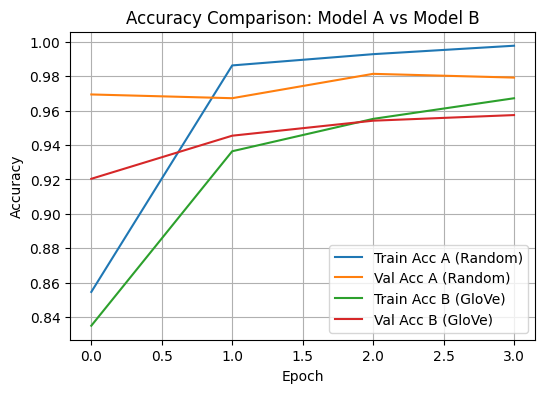

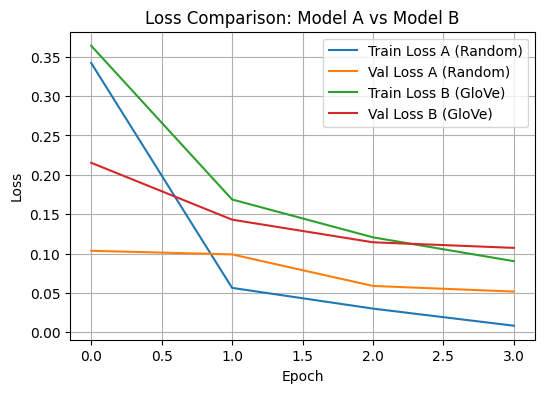

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,4))
plt.plot(history_a.history['accuracy'], label='Train Acc A (Random)')
plt.plot(history_a.history['val_accuracy'], label='Val Acc A (Random)')
plt.plot(history_b.history['accuracy'], label='Train Acc B (GloVe)')
plt.plot(history_b.history['val_accuracy'], label='Val Acc B (GloVe)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Model A vs Model B')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(6,4))
plt.plot(history_a.history['loss'], label='Train Loss A (Random)')
plt.plot(history_a.history['val_loss'], label='Val Loss A (Random)')
plt.plot(history_b.history['loss'], label='Train Loss B (GloVe)')
plt.plot(history_b.history['val_loss'], label='Val Loss B (GloVe)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison: Model A vs Model B')
plt.legend()
plt.grid()
plt.show()
